**Zusammenfassung EDA im Rahmen CRISP-DM**

**1. Business Understanding**
- Ziel: Churner (`Exited`) erkennen & Kundenerhalt verbessern.
- Wirtschafltichkeit im Rahmen der Kosten Kundenerhalt vs. Neukundenakquise -> im nachfolgenden Klassifikationsnotebook behandelt

**2. Data Understanding -> EDA**
- Datenimport & Exploration
- Variablenbeschreibung & vertiefende Exploration.
- Identifikation: Keine fehlenden Werte, keine Duplikate, starke Zielklassen-Imbalance (20 % Exit). 
- -> Resultierende Feature Engineering und Preprocessing für Modellleistung!

**3. Data Preparation**
- *Feature Engineering*:
  - Neue Features: `no_balance`, `multiproduct`, `saving_rate`
- *Feature Selection*:
  - Drop: IDs, Surname, Target Leakage Variablen sowie Original-NumOfProducts (ersetzt).
- *Preprocessing*:
  - Kategoriale Variablen: One-Hot-Encoding.
  - Numerische Variablen: Skalierung (StandardScaler) + partiell Winsoring.
- *Profiling*:
  - Automatisiertes Reporting vor & nach Preprocessing.
- *Data Balancing*
  - Mehrere Sampling-Strategien für Imbalance-Handling: Kein Resampling, Undersampling Oversampling, SMOTE & BorderlineSMOTE
  - Vergleich & Visualisierung aller Methoden (PCA, t-SNE, UMAP).

**Wesentliche Einstellungen/Strukturen**
- Reproduzierbarkeit via `RANDOM_STATE = 42`.
- Pfade & Zielvariable via Config-Klasse.
- Klare Zuweisung: welche Spalte wie verarbeitet wird.

**ExplorationImbalance Handling**
- Resampling (Under, Over, SMOTE, BorderlineSMOTE) & Visualisierung.

**Fazit**
- Das Notebook setzt zu Beginn alle zentralen Grundlagen für die Phasen "Business Understanding“, „Data Understanding“ und „Data Preparation“ gemäß CRISP-DM um – inkl. Feature Engineering, Skalierung, Kategorisierung und Imbalance-Handling.

# Library

In [1]:
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Report
from ydata_profiling import ProfileReport

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Imbalanced Data
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')


# Config

In [2]:
class Config:
    #PATH
    BASE_DIR = Path.cwd()
    PATH_DATA = BASE_DIR / "input" / "data_churn_bank.csv"
    PATH_DATA_REPORT_RAW = BASE_DIR / "output" / "data_raw_report.html"
    PATH_DATA_REPORT_PREPROCESSED = BASE_DIR / "output" / "data_preprocessed_report.html"

    # Reproduzierbarkeit
    RANDOM_STATE = 42

    # Zielvariable
    TARGET_COL = "Exited"

cfg = Config()
%matplotlib inline

# EDA

## Data Collection

In [3]:
# Laden der Daten
df_data = pd.read_csv(cfg.PATH_DATA, index_col=0)

df_data.info()
df_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerId          10000 non-null  int64  
 1   Surname             10000 non-null  object 
 2   CreditScore         10000 non-null  int64  
 3   Geography           10000 non-null  object 
 4   Gender              10000 non-null  object 
 5   Age                 10000 non-null  int64  
 6   Tenure              10000 non-null  int64  
 7   Balance             10000 non-null  float64
 8   NumOfProducts       10000 non-null  int64  
 9   HasCrCard           10000 non-null  int64  
 10  IsActiveMember      10000 non-null  int64  
 11  EstimatedSalary     10000 non-null  float64
 12  Exited              10000 non-null  int64  
 13  Complain            10000 non-null  int64  
 14  Satisfaction Score  10000 non-null  int64  
 15  Card Type           10000 non-null  object 
 16  Point Ear

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
RowNumber,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377


## Data Exploration

### Feature Description

| Col Variable        | Beschreibung                                                      | Datentyp  |
|---------------------|-------------------------------------------------------------------|-----------|
| `CustomerId`        | Eindeutige Kundenkennung                                          | Numerical |
| `Surname`           | Nachname des Kunden                                               | Category  |
| `CreditScore`       | Score des Kunden zur Kreditwürdigkeit (300–850)                   | Numerical |
| `Geography`         | Wohnort/Region des Kunden                                         | Category  |
| `Gender`            | Geschlecht des Kunden                                             | Category  |
| `Age`               | Alter des Kunden                                                  | Numerical |
| `Tenure`            | Anzahl Jahre als Kunde bei der Bank                               | Numerical |
| `Balance`           | Kontostand des Kunden                                             | Numerical |
| `NumOfProducts`     | Anzahl der vom Kunden genutzten Bankprodukte                      | Numerical |
| `HasCrCard`         | Besitz einer Kreditkarte (0 = nein, 1 = ja)                       | Numerical |
| `IsActiveMember`    | Aktiver Kontostatus (0 = inaktiv, 1 = aktiv)                      | Numerical |
| `EstimatedSalary`   | Geschätztes jährliches Gehalt                                     | Numerical |
| `Exited`            | Zielvariable: Kunde hat Bank verlassen (0 = nein, 1 = ja)         | Numerical |
| `Complain`          | Kunde hat sich beschwert oder nicht                               | Numerical |
| `Satisfaction Score`| Bewertungsscore für die erhaltene Hilfe zur Beschwerde            | Numerical |
| `Card Type`         | Kartentyp                                                         | Category  |
| `Point Earned`      | Durch Kreditkarte verdiente Punkte                                | Numerical |


### YData Profiling

In [4]:
# Erstellen eines Profiling-Berichts für die Rohdaten
profile = ProfileReport(
    df_data,
    minimal=False,
    interactions={"targets": [cfg.TARGET_COL]} # add focus on target column
)

profile.to_file(cfg.PATH_DATA_REPORT_RAW)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 4630.68it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Zusätzliches Erkenntnisinteresse
Einfluss Kategorien auf Zielvariable

## Balkendiagramme: Anteil pro Kategorie bezogen auf Gesamtdatenratio ##

NumOfProducts     1     2    3    4
Exited                             
0              36.8  42.4  0.5  0.0
1              14.1   3.5  2.2  0.6


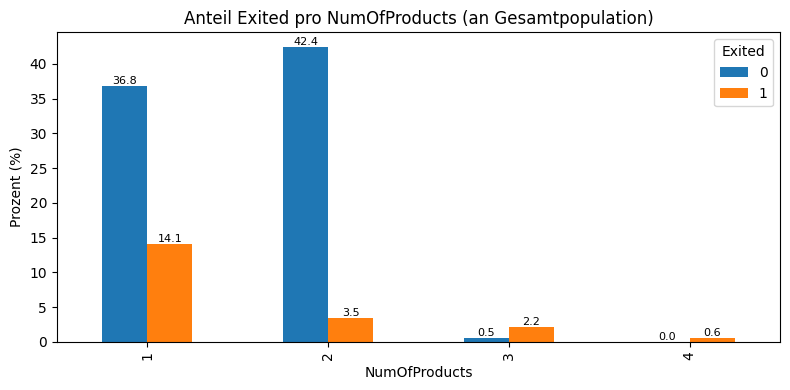

IsActiveMember     0     1
Exited                    
0               35.5  44.2
1               13.0   7.4


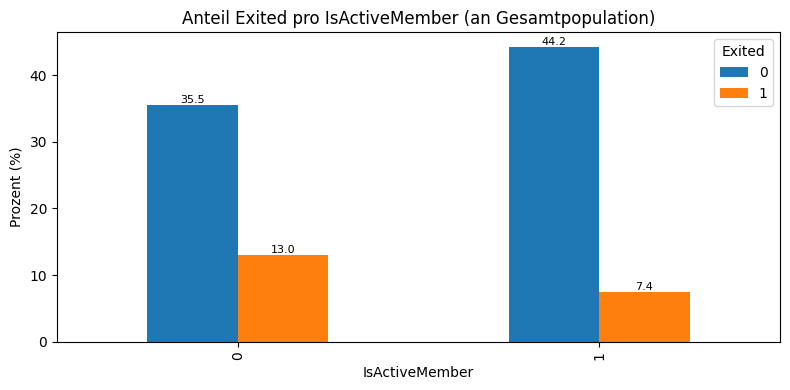

Geography  France  Germany  Spain
Exited                           
0            42.0     17.0   20.6
1             8.1      8.1    4.1


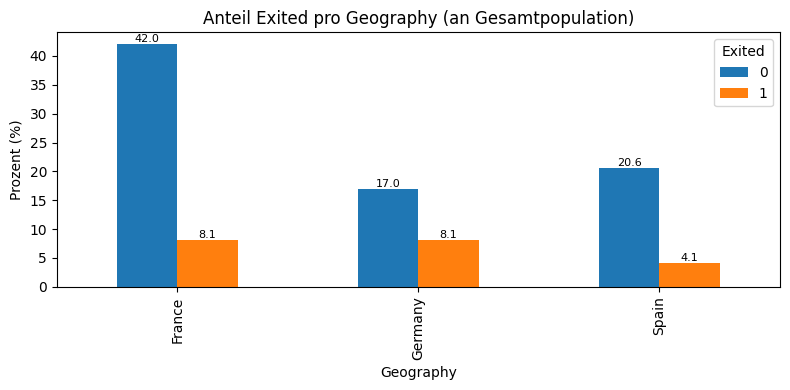

HasCrCard     0     1
Exited               
0          23.3  56.3
1           6.1  14.2


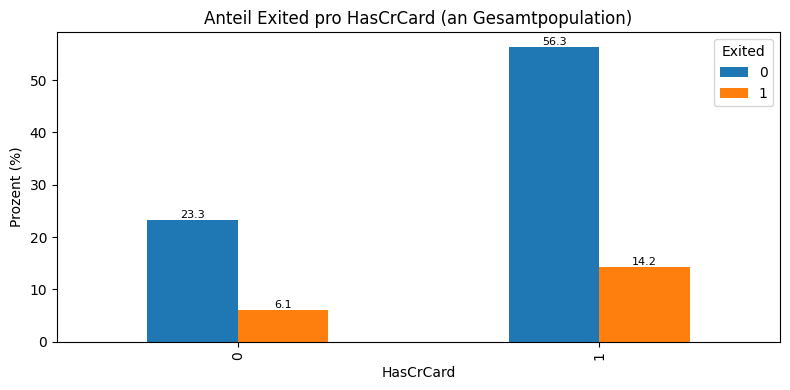

Gender  Female  Male
Exited              
0         34.0  45.6
1         11.4   9.0


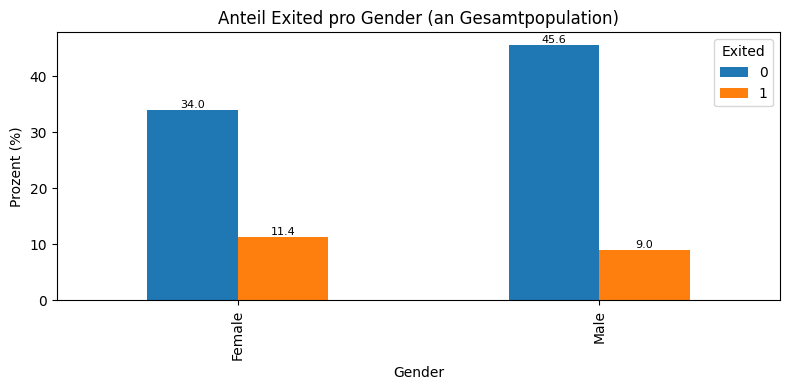

Complain     0     1
Exited              
0         79.5   0.1
1          0.0  20.3


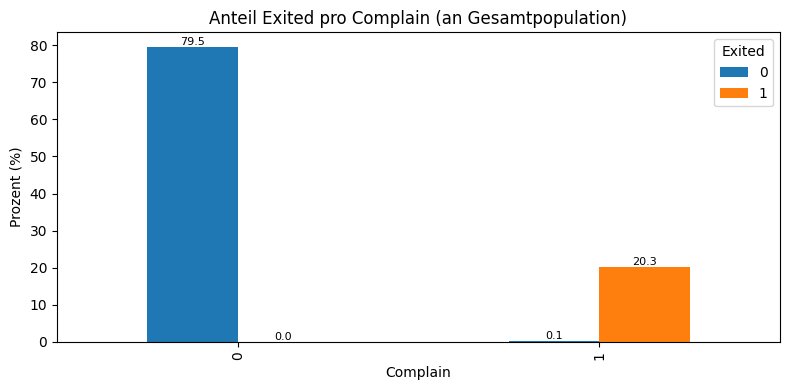

Card Type  DIAMOND  GOLD  PLATINUM  SILVER
Exited                                    
0             19.6  20.2      19.9    19.9
1              5.5   4.8       5.1     5.0


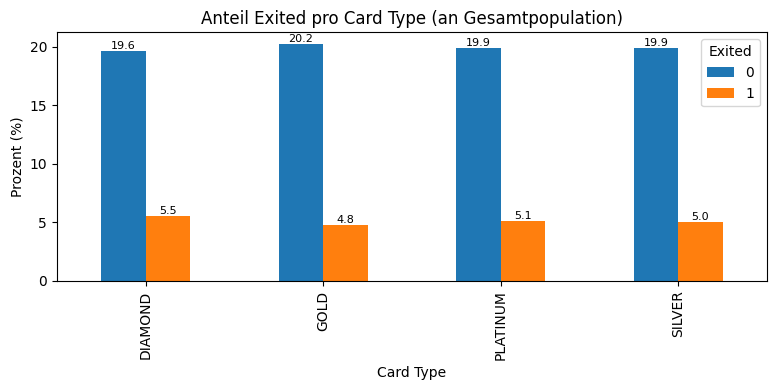

In [5]:
print("## Balkendiagramme: Anteil pro Kategorie bezogen auf Gesamtdatenratio ##\n")
for col in ['NumOfProducts', 'IsActiveMember', 'Geography', 'HasCrCard', 'Gender', 'Complain', 'Card Type']:
    freq = df_data.groupby(cfg.TARGET_COL)[col].value_counts().unstack(fill_value=0)
    freq = ((freq / len(df_data)) * 100).round(1)
    print(freq)

    ax = freq.T.plot(kind='bar', figsize=(8,4))
    plt.title(f'Anteil {cfg.TARGET_COL} pro {col} (an Gesamtpopulation)')
    plt.ylabel('Prozent (%)')
    plt.xlabel(col)
    plt.legend(title=cfg.TARGET_COL)
    plt.tight_layout()

    # Werte über die Balken
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.show()


### Profiling Results

**Datensatz**
- 16 Variablen à 10k Beaobachtungen
- Keine fehlenden Werte
- Keine Duplikate
- (!) Target leakage bei Complain ()
<br></br>

**Resultat Verteilung**

Für das Preprocessing wird eine einheitliche Pipeline angestrebt. Somit gilt der kleinste gemeinsame Nenner bezüglich Eigenschaft der Inputvariablen. Da lineare Modelle wie Logistische Regression anfälliger sind für Skalierung numerischer Daten wird der Einsatz eines Standardscalers vorgesehen, um alle numerischen Features auf Mittelwert 0 und Standardabweichung 1 zu transformieren. Dadurch wird auch eine konsistente Modellperformance und Vergleichbarkeit zwischen verschiedenen Algorithmen sichergestellt. Zudem kann das Modell nicht mit kategorialen Daten umgehen, weshalb diese One-Hot-Encoded werden müssen. 

| Variable               | Type      | Fehlend | Verteilung                                               | Relevanter linearer Zusammenhang Target              | Resultierendes Preprocessing                                        |
|------------------------|-----------|---------|----------------------------------------------------------|------------------------------------------------------|---------------------------------------------------------------------|
| ORIGNAL DATASET        |           |         |                                                          |                                                      |                                                                     |
| `CustomerId`           | cat       | Nein    | -                                                        | -                                                    | Drop, nicht relevant                                                |
| `Surname`              | cat       | Nein    | Textvariable, viele Unique-Werte                         | nicht geprüft                                        | Drop, persönlicher Nachname                                         |
| `CreditScore`          | num       | Nein    | ~Normalverteilung, Peak bei 850                          | -                                                    | Skalieren (StandardScaler)                                          |
| `Geography`            | cat       | Nein    | Fra 50%, Ger 25%, Spa 25%                                | (Ger) 47% churn > (Fra, Spa) 20% churn               | One-Hot-Encoding                                                    |
| `Gender`               | cat       | Nein    | Ausgeglichen (≈ 50/50)                                   | (w) 32% churn > (m) 20%                              | One-Hot-Encoding                                                    |
| `Age`                  | num       | Nein    | ~Normalverteilung, leicht rechtsschief                   | corr = 0.38                                          | Skalieren (StandardScaler), ggf. Log/Power-Transform                |
| `Tenure`               | num       | Nein    | Gleichverteilt, aber Randhäufungen halbiert              | -                                                    | Skalieren (StandardScaler)                                          |
| `Balance`              | num       | Nein    | Bimodal punktmassig 33 % : 0 + ~Normalverteilung     | -                                                    | Skalieren (StandardScaler), neue Binärvariable `has_balance`        |
| `NumOfProducts`        | num       | Nein    | 1–4; 3/4 selten (3%)                                     | (3, 4): 82% churn > (1) 28% > (2) 1% churn           | (3+4) 3% minority → red flag behalten, rest Binarisierung           |
| `HasCrCard`            | cat       | Nein    | 30 % Ja, 70 % Nein, Imbalanced                           | -                                                    | Belassen → ja/nein                                                  |
| `IsActiveMember`       | cat       | Nein    | Gleichverteilung                                         | (False) 37% churn > (True) 15 % churn                | Belassen → ja/nein                                                  |
| `EstimatedSalary`      | num       | Nein    | Gleichverteilung                                         | -                                                    | Skalieren (StandardScaler)                                          |
| `Exited`               | cat       | Nein    | 20 % Ja, 80 % Nein                                       | x                                                    | Target → Imbalance lösen: class_weight oder sampling                |
| KAGGLE DATASET+        |           |         |                                                          |                                                      |                                                                     |
| `Complain`             | cat       | Nein    | 20 % Ja, 80 % Nein, Imbalanced                           | corr = 0.99 (!)                                      | Drop, da Target leakage                                             |
| `Satisfaction Score`   | num       | Nein    | Gleichverteilung                                         | unüblich (corr = 0)                                  | Drop, da resultiert aus Target leakage + unsinnige Corr             |
| `Card Type`            | cat       | Nein    | Gleichverteilung                                         | -                                                    | One-Hot-Encoding                                                    |
| `Point Earned`         | num       | Nein    | Mehrheitlich leicht schwankende Gleichverteilung         | -                                                    | Skalieren (StandardScaler)                                          |
| FEATURE ENGINEERING    |           |         |                                                          |                                                      |                                                                     |
| `has_balance`          | cat       | Nein    | 30 % Ja, 70 % Nein, Imbalanced                           | -                                                    | (Neues Feature!)                                                    |
| `multiproduct`         | cat       | Nein    | Ausgeglichen durch Aggregierung                          | -                                                    | (Neues Feature!)                                                    |
| `saving_rate`          | num       | Nein    | Resultierend durch Balance: Bimodal + Ausreißer          | -                                                    | (Neues Feature!) Rechts-Winsoring gegen Ausreißer                   |


<br></br>
**Feature Engineering**
| Neues Feature           | Beschreibung                                                                                                    |
|-------------------------|-----------------------------------------------------------------------------------------------------------------|
| `has_balance`           | Binär: 1, wenn `Balance > 0`, sonst 0. Trennt Kunden mit/ohne Guthaben.                                         |
| `multiproduct`          | Binär: 1, wenn `NumOfProducts ≥ 2`, sonst 0. Markiert Mehrfachkunden.                                           |
| `multiproduct_redflag`  | Binär: 1, wenn `NumOfProducts > 2`, sonst 0. Signalisiert Risikogruppe (Minority).                              |
| `saving_rate`           | Verhältnis `EstimatedSalary` zu `Balance`. Misst Sparkquote/Spending relativ zum Einkommen (Vermögensaufbau).   |



In [6]:
# Variablen Mapping Preprocessing
cols_to_drop        = ["CustomerId", "Surname"] + ["Complain", "Satisfaction Score"] + ["NumOfProducts"] # NumOfProducts -> multiproduct 
cols_to_ohe         = ["Geography", "Gender"] + ["Card Type"]
cols_to_scale       = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"] + ["Point Earned"]

## Data Preprocessing

### Feature Engineering

In [7]:
# Feature Engineering
df_data["no_balance"]               = (df_data["Balance"] == 0).astype(int)
df_data["multiproduct"]             = (df_data["NumOfProducts"] > 1).astype(int)
df_data["multiproduct_red_flag"]    = (df_data["NumOfProducts"] > 2).astype(int)
df_data["saving_rate"]              = np.log1p(df_data["Balance"]) / np.log1p(df_data["EstimatedSalary"])
cols_to_scale = cols_to_scale + ["saving_rate"]

df_data[["no_balance", "multiproduct", "multiproduct_red_flag", "saving_rate"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no_balance             10000 non-null  int64  
 1   multiproduct           10000 non-null  int64  
 2   multiproduct_red_flag  10000 non-null  int64  
 3   saving_rate            10000 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 648.7 KB


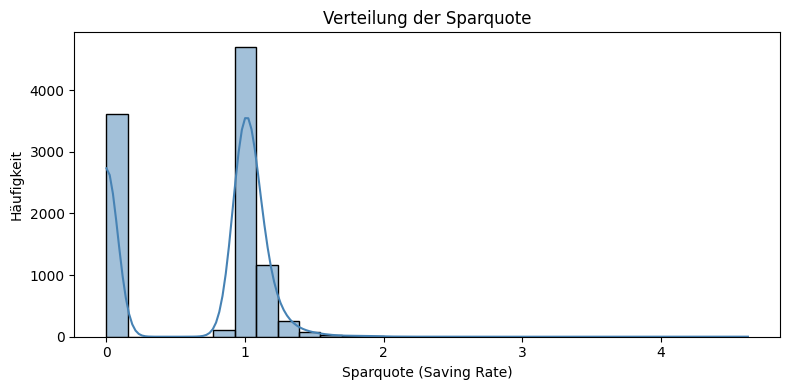

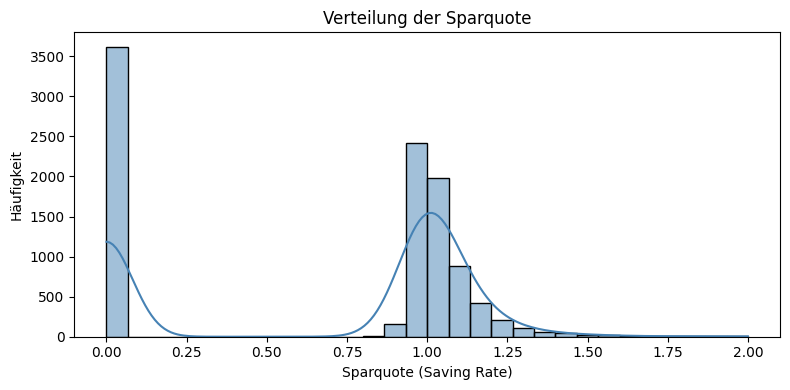

In [8]:
# Exploration Verteilung neuer Features
plt.figure(figsize=(8, 4))
sns.histplot(df_data["saving_rate"], kde=True, bins=30, color='steelblue', edgecolor='black')
plt.title("Verteilung der Sparquote", fontsize=12)
plt.xlabel("Sparquote (Saving Rate)")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()


# Winsorizing der Sparquote wegen Ausreißern
df_data["saving_rate"] = df_data["saving_rate"].clip(lower=0, upper=2)

plt.figure(figsize=(8, 4))
sns.histplot(df_data["saving_rate"], kde=True, bins=30, color='steelblue', edgecolor='black')
plt.title("Verteilung der Sparquote", fontsize=12)
plt.xlabel("Sparquote (Saving Rate)")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()



### Feature Selection

In [9]:
# Drop redundante Variablen
df_data_selected = df_data.drop(columns=cols_to_drop)
df_data_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CreditScore            10000 non-null  int64  
 1   Geography              10000 non-null  object 
 2   Gender                 10000 non-null  object 
 3   Age                    10000 non-null  int64  
 4   Tenure                 10000 non-null  int64  
 5   Balance                10000 non-null  float64
 6   HasCrCard              10000 non-null  int64  
 7   IsActiveMember         10000 non-null  int64  
 8   EstimatedSalary        10000 non-null  float64
 9   Exited                 10000 non-null  int64  
 10  Card Type              10000 non-null  object 
 11  Point Earned           10000 non-null  int64  
 12  no_balance             10000 non-null  int64  
 13  multiproduct           10000 non-null  int64  
 14  multiproduct_red_flag  10000 non-null  int64  
 15  saving_

### OHE + Scaling

In [10]:
# OHE auf cols_to_ohe
df_data_preprocessed = pd.get_dummies(df_data_selected, columns=cols_to_ohe, drop_first=True)
df_data_preprocessed = df_data_preprocessed.apply(lambda col: col.astype(int) if col.dtype == bool else col)

### Scaling numerischer Variablen
scaler = StandardScaler()
df_data_preprocessed[cols_to_scale] = scaler.fit_transform(df_data_preprocessed[cols_to_scale])

### Überprüfe manuelle Preprocessing Resultate

In [11]:
profile = ProfileReport(
    df_data_preprocessed,
    minimal=False,
    interactions={"targets": [cfg.TARGET_COL]} # add focus on target column
)

profile.to_file(cfg.PATH_DATA_REPORT_PREPROCESSED)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 618.14it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Imbalance Solutions
**Imbalance problem:** Due to the class imblance of 20% exits and 80% non exits, we want to avoid that especially standard models learn on the majority class. This is important as we want to achieve a high recall which depends on a well modeled minority class.

## Apply Resampling

In [12]:
X = df_data_preprocessed.drop(columns=[cfg.TARGET_COL])
y = df_data_preprocessed[cfg.TARGET_COL]

sampling_methods = [
    ('none', None),
    ('undersample', RandomUnderSampler(random_state=cfg.RANDOM_STATE)),     # zufällige Reduktion der Mehrheitsklasse
    ('oversample', RandomOverSampler(random_state=cfg.RANDOM_STATE)),       # zufällige Erhöhung der Exited-Fälle
    ('smote', SMOTE(random_state=cfg.RANDOM_STATE)),                        # synthetische Exited-Fälle im gesamten Feature-Raum interpoliert
    ('borderlinesmote', BorderlineSMOTE(random_state=cfg.RANDOM_STATE))     # synthetische Exited-Fälle gezielt an den Entscheidungsgrenzen
]

In [13]:
results = []
resampled_data = dict()

# Resampling Methoden anwenden
for name, sampler in sampling_methods:
    if sampler is not None:
        pipe = ImbPipeline([('sampling', sampler)])
        X_res, y_res = pipe.fit_resample(X, y)
    else:
        X_res, y_res = X.copy(), y.copy()

    resampled_data[name] = {'X': X_res, 'y': y_res}

    results.append({
        'Methode': name,
        'X_res_shape': X_res.shape,
        'y_res_verteilung': y_res.value_counts().to_dict(),
        'Sampler verwendet': sampler is not None
    })

resampling_df = pd.DataFrame(results)
print(resampling_df)

           Methode  X_res_shape    y_res_verteilung  Sampler verwendet
0             none  (10000, 18)  {0: 7962, 1: 2038}              False
1      undersample   (4076, 18)  {0: 2038, 1: 2038}               True
2       oversample  (15924, 18)  {1: 7962, 0: 7962}               True
3            smote  (15924, 18)  {1: 7962, 0: 7962}               True
4  borderlinesmote  (15924, 18)  {1: 7962, 0: 7962}               True


## Visualization of Resampling

In [14]:
# Visualisierung der Resampling Ergebnisse
def get_synthetic_mask(method, X_orig, X_res):
    if method in ['smote', 'borderlinesmote']:
        n_orig = len(X_orig)
        mask = np.zeros(len(X_res), dtype=bool)
        mask[n_orig:] = True
        return mask
    else:
        return np.zeros(len(X_res), dtype=bool)

# Berechnung der Embeddings für die Visualisierung
def compute_embeddings(X, random_state=42):
    # PCA
    pca = PCA(n_components=2, random_state=random_state)
    emb_pca = pca.fit_transform(X)
    # t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=30)
    emb_tsne = tsne.fit_transform(X)
    # UMAP
    emb_umap = umap.UMAP(n_components=2, random_state=random_state).fit_transform(X)
    return [emb_pca, emb_tsne, emb_umap], ['PCA', 't-SNE', 'UMAP']

# Plotten der Embeddings für alle Resampling-Methoden
def plot_all_embeddings(X_res, y_res, mask_synth, method, random_state=42, max_samples=4000):
    idx_sample = np.random.RandomState(random_state).choice(
        len(X_res), size=min(max_samples, len(X_res)), replace=False
    )
    X_plot = X_res.iloc[idx_sample] if hasattr(X_res, 'iloc') else X_res[idx_sample]
    y_plot = y_res.iloc[idx_sample] if hasattr(y_res, 'iloc') else y_res[idx_sample]
    mask_plot = mask_synth[idx_sample]

    # Farben: 0=grau, 1=rot, synthetisch=orange
    color_map = {0: "#7E7E7E", 1: "#D62728"}
    synth_color = "#FFA500"  # orange

    emb_list, emb_names = compute_embeddings(X_plot, random_state=random_state)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (emb, name) in enumerate(zip(emb_list, emb_names)):
        ax = axes[i]
        # Originalpunkte (Kreise)
        for exit_val in [0, 1]:
            idx = (~mask_plot) & (y_plot.values == exit_val)
            ax.scatter(
                emb[idx, 0], emb[idx, 1],
                c=color_map[exit_val], s=18, marker='o', label=f'Original, Exit={exit_val}'
            )
        # Synthetische Punkte (X, orange, leicht transparent)
        if mask_plot.any():
            ax.scatter(
                emb[mask_plot, 0], emb[mask_plot, 1],
                c=synth_color, s=50, marker='x', alpha=0.7, label='Synthetisch'
            )
        if i == 0:
            ax.legend(loc='best')
        ax.set_title(f"{name} ({method})")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

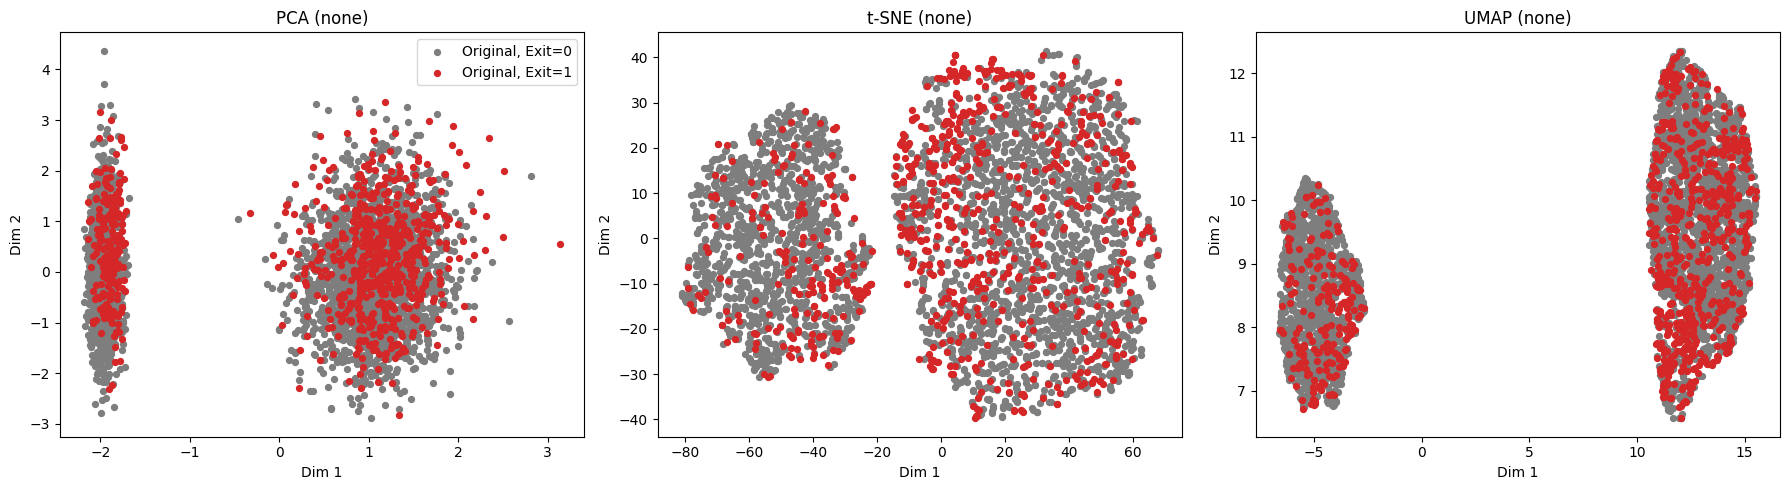

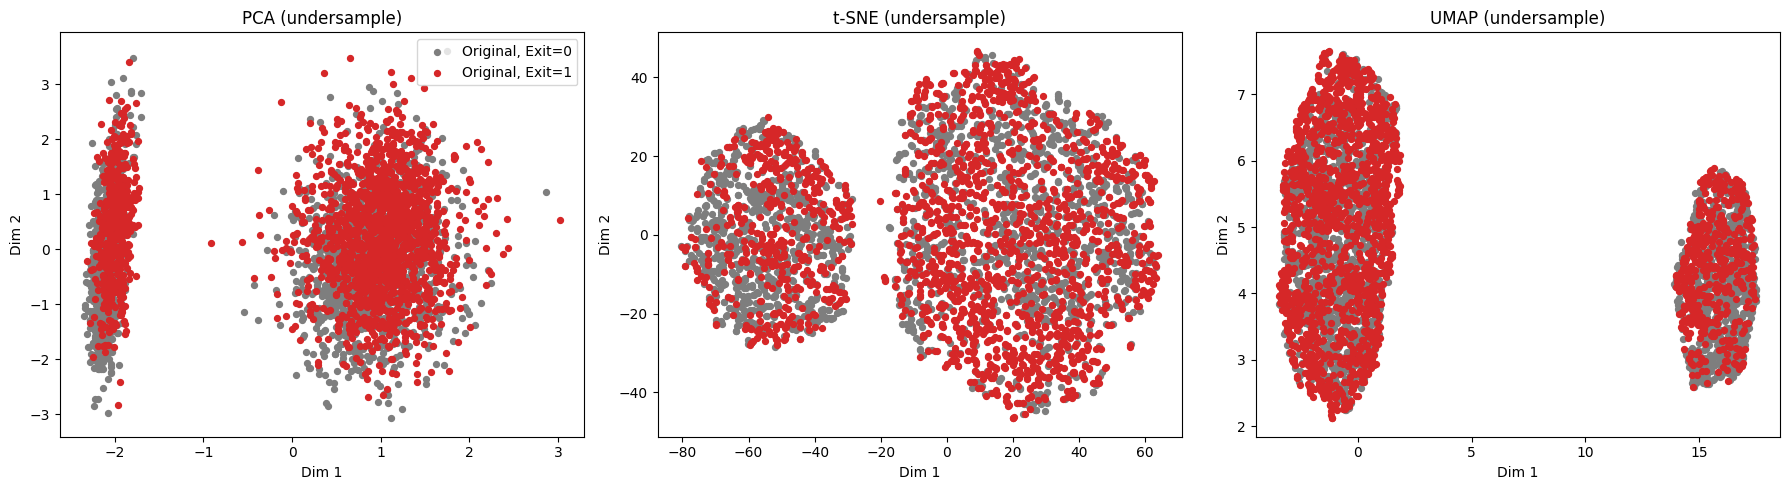

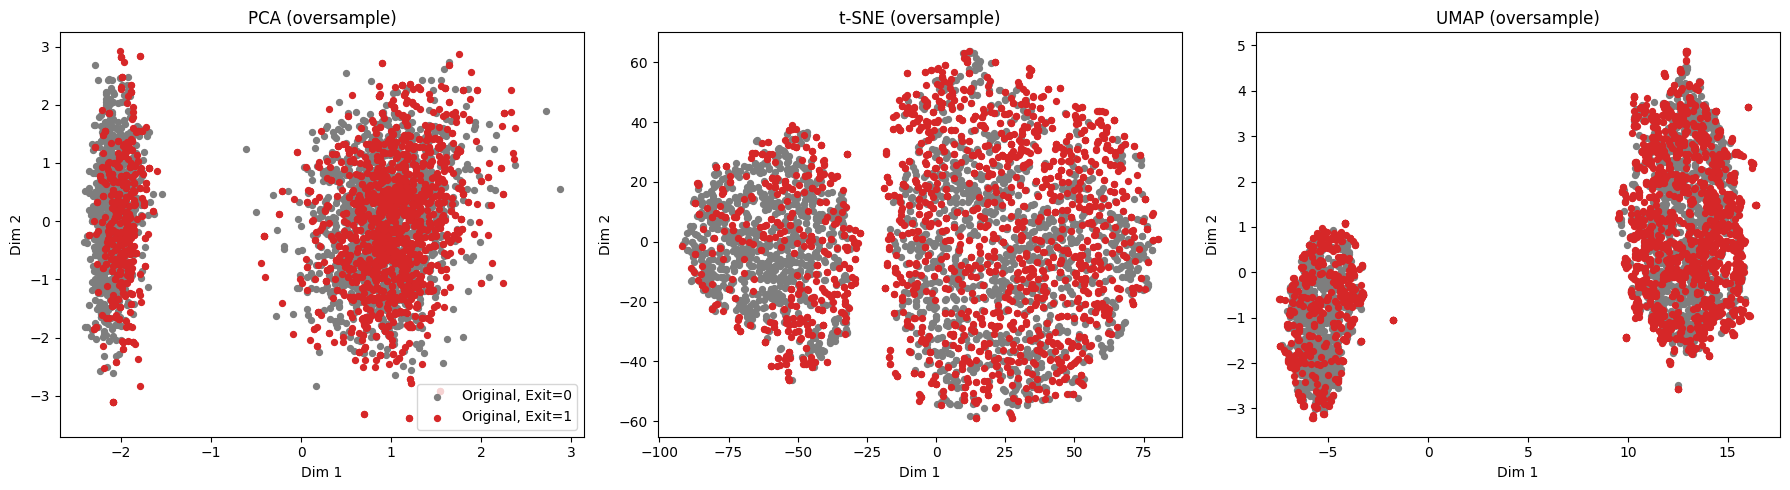

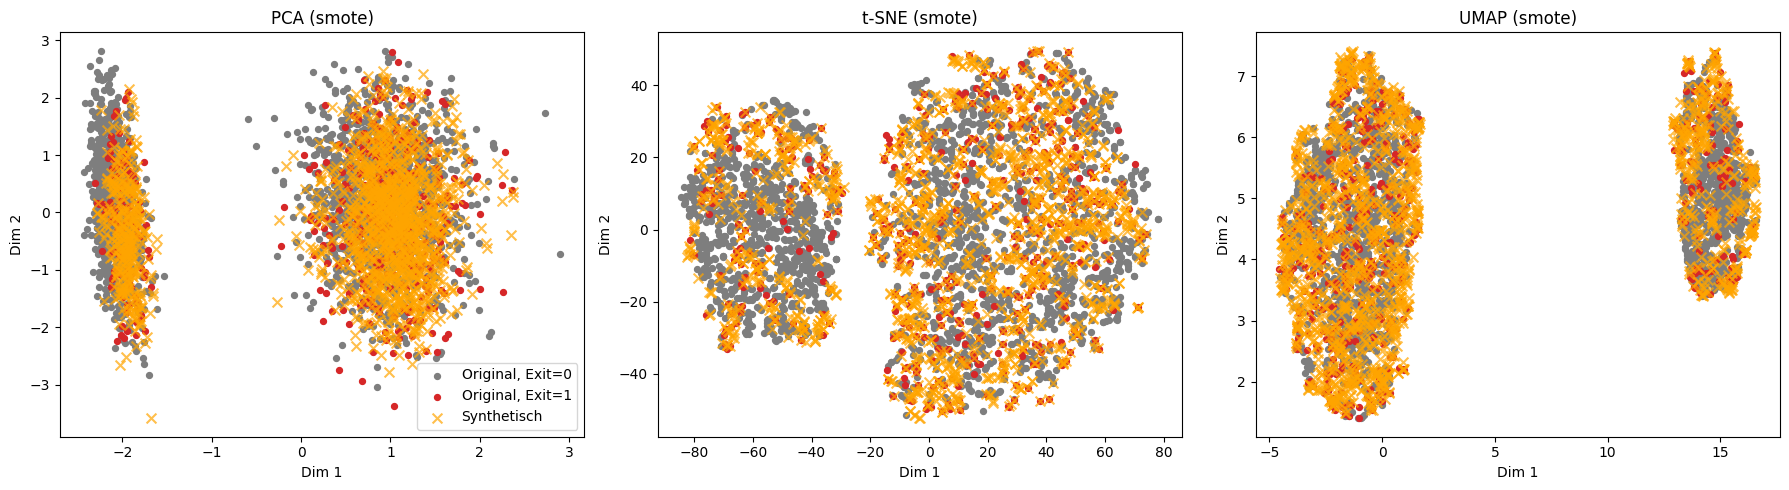

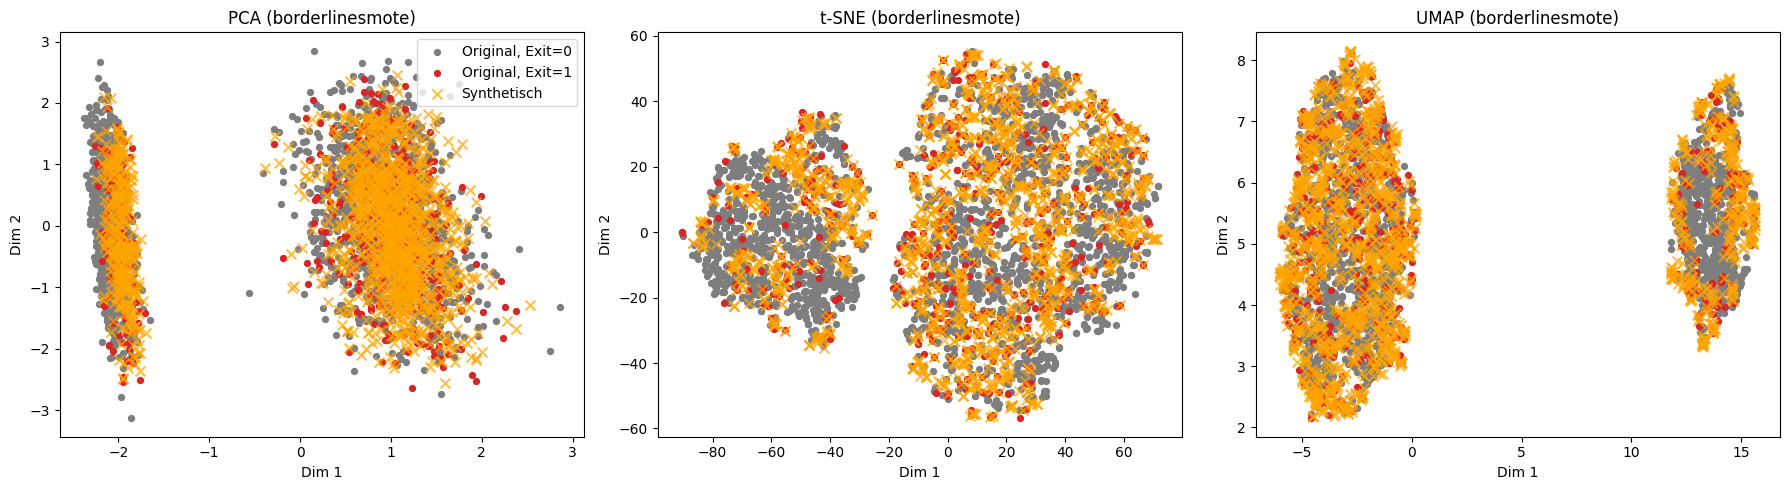

In [15]:
# Visualisierung für alle Sampling-Methoden
for method, _ in sampling_methods:
    X_res = resampled_data[method]['X']
    y_res = resampled_data[method]['y']
    mask_synth = get_synthetic_mask(method, X, X_res)
    plot_all_embeddings(X_res, y_res, mask_synth, method, random_state=cfg.RANDOM_STATE, max_samples=4000)
